# Your name: Joe Gelsomini

# Introduction
This homework consists of two parts: the first one is a theoritical problem and the second one focuses on the classification task. Text classification is a well-addressed task in NLP and it aims to assign a label to a given document (i.e. training example). You are  going to run and then compare a conventional machine learning model with a deep learning model that uses a recurrent neural network. In this part of the homework, you are expected to be familiar with conventional machine learning models. Note that this homework relies on `sklearn` library that is by far the most popular library in Python to run conventional ML models. If you go to its' documentation, you will find a lot of useful information on how to run and evaluate your models, how to extract useful features and transform the dataset; the documentation has a lot of examples that you can refer to.

In the theoretical problem, you will be comparing different language models applied to a span of text.

__You will need__ to have the following libraries installed (please make sure you followed the installation instructions in the class repository to install them):
- [NLTK](http://www.nltk.org/)
- [NumPy](http://www.numpy.org/)
- [PyTorch](https://pytorch.org/)
- [scikit-learn](https://scikit-learn.org/stable/) (`pip install sklearn`)


__You will learn:__
- How a language model works
- How to represent input text using the TF-IDF algorithm
- How to run conventional machine learning models for text classification
- How to train a Recurrent Neural Network

Once you complete this assignment, submit it as:

`submit arum hw4 <name_of_your_notebook> <additional_files>`


In [1]:
# Make sure that execution of this cell doesn't return any errors. If it does, go the class repository and follow the environment setup instructions
import random
import itertools
from collections import Counter, defaultdict
import string
import json

import torch
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize, sent_tokenize #added sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC

plt.style.use('seaborn')
%matplotlib inline

# 1. Language model
In this problem, we will be computing probabilities assigned to a particular word sequence by different [language models](https://en.wikipedia.org/wiki/Language_model), given the training data below. You are not required to submit any code for this problem.

__Instructions__:
- paste your answers to the following questions into the notebook.
- if you do write your own code to solve the problem, please include it, otherwise please sumbit additional files showing your work.

```
Harold Jones , Lincoln ’s chief retail banking officer , said there has n’t yet been “ a discernible response , ” although the ad included a coupon that could arrive later in the week .
In a move which could pose a new competitive challenge to Time Warner Inc. ’s powerful Home Box Office , cable giant Tele-Communications Inc. agreed to buy half of Showtime Networks Inc.
from Viacom Inc. for 225 million. The oil and auto industries , united in their dislike of President Bush ’s proposal for cars that run on alternative fuels , announced a joint research program which could turn up a cleaner-burning gasoline. The derivative mortgage-backed market revived after the news about two more issues that could be priced today. Japanese air-conditioner maker Daikin Industries Ltd. was fined two million yen for exporting to the Soviet Union chemicals in a solution that could be used in missile-guidance systems. We at Ledbury Research believe there are knowledge gaps on both sides of the table. The above agreement must be signed by both parties and acknowledged by all sides. Tax returns will be accepted by the IRS electronically.
Friends long have found inspiration in George Fox ’s words, ”We seek a world free of war and thethreat of war”.
```

### 1.1 Compute the probability assigned to the following string by a bigram language model applied __without smoothing__:
`We seek a solution that could be accepted by both sides.`

In [2]:
# HW2 Function from sample solution courtesy of graders :)
# Slightly modified to convert all tokens to lower
def preprocess(data):
    """
    Args:
        data (str):
    Returns: a list of tokens

    """
    tokens = [t.lower() for t in word_tokenize(data) if t not in string.punctuation]
    return tokens

In [3]:
#create word doc
doc = "Harold Jones , Lincoln ’s chief retail banking officer , said there has n’t yet been “ a discernible response , ” although the ad included a coupon that could arrive later in the week. In a move which could pose a new competitive challenge to Time Warner Inc. ’s powerful Home Box Office , cable giant Tele-Communications Inc. agreed to buy half of Showtime Networks Inc. from Viacom Inc. for 225 million. The oil and auto industries , united in their dislike of President Bush ’s proposal for cars that run on alternative fuels , announced a joint research program which could turn up a cleaner-burning gasoline. The derivative mortgage-backed market revived after the news about two more issues that could be priced today. Japanese air-conditioner maker Daikin Industries Ltd. was fined two million yen for exporting to the Soviet Union chemicals in a solution that could be used in missile-guidance systems. We at Ledbury Research believe there are knowledge gaps on both sides of the table. The above agreement must be signed by both parties and acknowledged by all sides. Tax returns will be accepted by the IRS electronically. Friends long have found inspiration in George Fox ’s words, ”We seek a world free of war and the threat of war”."
sent = "We seek a solution that could be accepted by both sides"

#seperate sentences
sentences = sent_tokenize(doc)
marked_sents = []

#add a sentence start "<s>" and stop "</s>" token to each sentence
######Doing this gives much smaller probabilities, because of quotes in corpus#####
for sentence in sentences:
    tokens = preprocess(sentence)
    tokens.insert(0,'<s>')#can comment out
    tokens.append("</s>")#can comment out
    marked_sents.append(tokens)


#counts of unique tokens in doc
counts = Counter()
bigrams = []

for sentence in marked_sents:
    for i in range(len(sentence)):
        counts[sentence[i]] += 1
        if i+1 < len(sentence):
            bigrams.append((sentence[i], sentence[i+1]))

#make bigrams for sentence we want to compute probability of
sent = preprocess(sent)
sent_bigrams = []

####You can comment out the start and end markers to get smaller probabilities
sent.insert(0,"<s>")#can be removed
sent.append("</s>")#can be removed
for i in range(len(sent)-1):
    if i+ 1 < len(sent):
        sent_bigrams.append((sent[i],sent[i+1]))
        
#now have everything we need to cmpute the probability of the sentence, with and without absolute discounting
probability = 1
probability_abs = 1
for bg in sent_bigrams:
    print("P of:", bg[1],"given",bg[0], (bigrams.count(bg)/(counts[bg[0]])))
    probability *= (bigrams.count(bg)/(counts[bg[0]]))
    #probability_abs *= (bigrams.count(bg) -0.03 )/ (counts[bg[0]])
    
print("\nProbability of sentence:",probability)


#print("\nBigrams generated:\n",bigrams)

P of: we given <s> 0.1111111111111111
P of: seek given we 0.5
P of: a given seek 1.0
P of: solution given a 0.125
P of: that given solution 1.0
P of: could given that 0.75
P of: be given could 0.4
P of: accepted given be 0.25
P of: by given accepted 1.0
P of: both given by 0.3333333333333333
P of: sides given both 0.5
P of: </s> given sides 0.5

Probability of sentence: 4.340277777777777e-05


### 1.2. Compute the probability assigned to the above string by a bigram language model with __absolute discounting (δ =.03)__.

In [4]:
probability_abs = 1
for bg in sent_bigrams:
    print("P absolute of:", bg[1], "given", bg[0], (bigrams.count(bg) - 0.03) / (counts[bg[0]]) )
    probability_abs *= (bigrams.count(bg) - 0.03 )/ (counts[bg[0]])
          
print("\nProbability with absolute discounting:",probability_abs,"\n")

P absolute of: we given <s> 0.10777777777777778
P absolute of: seek given we 0.485
P absolute of: a given seek 0.97
P absolute of: solution given a 0.12125
P absolute of: that given solution 0.97
P absolute of: could given that 0.7425
P absolute of: be given could 0.394
P absolute of: accepted given be 0.2425
P absolute of: by given accepted 0.97
P absolute of: both given by 0.3233333333333333
P absolute of: sides given both 0.485
P absolute of: </s> given sides 0.485

Probability with absolute discounting: 3.1210900058228693e-05 



# Text classification

## 2. News Category Dataset
This dataset is a collection of headlines and the corresponding categories obtained from [HuffPost](https://www.huffingtonpost.com/). This dataset is publicly available on the Kaggle Platform: [https://www.kaggle.com/rmisra/news-category-dataset/](https://www.kaggle.com/rmisra/news-category-dataset/) In total, it contains 41 categories with a different number of samples in each category. For the sake of simplicity, in this homework we are going to use only 8 categories, listed below. Our classification task will be to predict the category of a given headline.

__Notes__:
Make sure the dataset is downloaded and unpacked to the same directory as this notebook.

__Instructions__:
- Run the cells below to load the dataset from the file

### 2.1 Reading the dataset from the file 

In [5]:
needed_categories = {
    'BUSINESS',
    'COMEDY',
    'FOOD & DRINK',
    'HEALTHY LIVING',
    'PARENTING',
    'QUEER VOICES',
    'STYLE & BEAUTY',
    'TRAVEL',
}

In [6]:
def load_dataset(filename, categories=None):
    samples = []
    with open(filename, 'r') as f:
        for line in f:
            sample = json.loads(line)
            if categories is None or sample['category'] in categories:
                samples.append(sample)
    return samples

In [7]:
data = load_dataset('News_Category_Dataset_v2.json', needed_categories)

# For convenience, let's store the headlines and the corresponding categories in separate lists
data_headlines = [x['headline'] for x in data]
data_labels = [x['category'] for x in data]

Let's print a random example to see what it looks like.

In [8]:
random_sample_idx = random.randrange(len(data))
print('Category:\n', data_labels[random_sample_idx])
print('Headline:\n', data_headlines[random_sample_idx])

Category:
 STYLE & BEAUTY
Headline:
 7 Hairstyles To Cross Off Your Bucket List


## 2.2 Now let's do the dataset analysis.

__Instructions__:
Complete the code in the cells below to answer the questions.

### 2.2.1 How many examples are there in the resulting dataset (i.e. in the subset of the original dataset)?

In [9]:
### YOUR CODE BELOW ###
num_examples = len(data_headlines)
### YOUR CODE ABOVE ###

print('There are {} examples'.format(num_examples))
#print("\n",data_headlines[0:10])

There are 58559 examples


### 2.2.2 Split the dataset into train and test subsets in the 70/30 ratio.

__Notes__:
- Use the `train_test_split` function from the `sklearn` library and __set the `random_state` argument to 10__. This is important for getting consistent results over multiple runs (and for grading).

In [10]:
### YOUR CODE BELOW ###
X_train, X_test, y_train, y_test = train_test_split(data_headlines, data_labels, test_size = .3, random_state = 10)
data_train = X_train
labels_train = y_train
data_test = X_test
labels_test = y_test
### YOUR CODE ABOVE ###

### 2.2.3 How many samples are there in the training split, and how many samples are there in the test split?

In [11]:
### YOUR CODE BELOW ###
num_train_examples = len(X_train)
num_test_examples = len(X_test)
#print(num_train_examples + num_test_examples, "total examples.")
### YOUR CODE ABOVE ###
print("There are {} training and {} test examples in the dataset.".format(num_train_examples, num_test_examples))

There are 40991 training and 17568 test examples in the dataset.


### 2.2.4 Plot the histogram of the class counts for both subsets.

__Notes__:
- In general, it is always a good idea to check the data distributions for your dataset splits.
- Use the `Counter` class from the `collections` library to count examples belonging to each of the classes

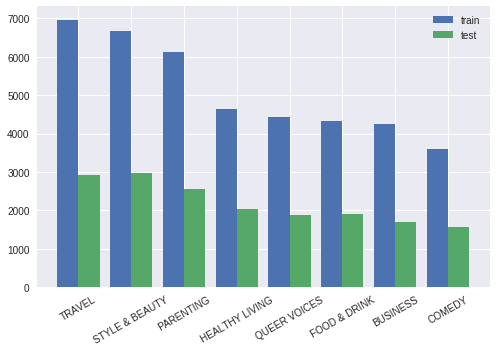

In [12]:
### YOUR CODE BELOW ###
counter_train = Counter()
counter_test = Counter()

for label in y_train:
    counter_train[label] +=1
for label in y_test:
    counter_test[label] +=1
    
### YOUR CODE ABOVE ###

names = [c for c, n in counter_train.most_common()]
index = np.arange(len(names))

values_train = [counter_train[c] for c in names]
values_test = [counter_test[c] for c in names]

fig, ax = plt.subplots(figsize=(7, 5))

ax.bar(index-0.2, values_train, label="train", width=0.4)
ax.bar(index+0.2, values_test, label="test", width=0.4)

ax.set_xticks(index)
ax.set_xticklabels(names, rotation=30)

ax.legend()
fig.tight_layout()

### 2.2.5 What is the most represented category in the dataset? What is the least represented category in the dataset?

In [13]:
counter_all = Counter()
for label in counter_train:
    counter_all[label] = counter_train[label] + counter_test[label]
print(counter_all.most_common()[0][0],"is the most frequent label in the data, with", 
      counter_all.most_common()[0][1], "instances.")
print(counter_all.most_common()[len(counter_all)-1][0], "is the most infrequent label, with",
      counter_all.most_common()[len(counter_all)-1][1], "instances.")

TRAVEL is the most frequent label in the data, with 9887 instances.
COMEDY is the most infrequent label, with 5175 instances.


## 3. TF-IDF

In previous homeworks you familiarized yourself with the simplest method for representing a given document in a corpus - through constructing a vector of raw word counts for every training example. While this method works for a number of tasks and datasets, a better alternative way of handling text is to use so-called TF-IDF representations.
[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) (term-frequency-inverse-document-frequency) is a common technique in NLP that is based on selecting the most important words for a given training example, where the importance of every word is defined by (a) how frequently it is used in the entire corpus, and (b) how frequently it is used in the given example. More specifically, if a given word is relatively rare for the entire collection of documents but it occurs many times within a single document, then this word is important for "defining" what this document is about. In the current step you will convert a set of texts to their TF-IDF representations. You will use the obtained representations as features for training text classification models later on. Sklearn library provides a `TfidfVectorizer` class that you are going to use (please refer to the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html))

__Instructions__:
- Complete the code in `transform_to_tfidf` that takes a collection of documents (train and test examples) and returns a list of corresponding TF-IDF vectors.
- In the cells below, run the function with the correct arguments and complete the coded where needed to answer the questions

__Notes__:
- There is no need for you to tokenize the input examples since `TfidfVectorizer` does it for you
- `TfidfVectorizer` returns a sparse array; you might want to convert it to the dense representation using `toarray()`
- Make sure to understand the difference between the following methods: `fit()`, `fit_transform()` and `transform()`. These methods are very common for sklearn pipeline and used not only for dataset processing, but also for model running and evaluating.



In [14]:
def transform_to_tfidf(train_corpus, test_corpus, max_df=1.0, min_df=1, stop_words=None):
    """
    Transform train and test documents to their TF-IDF representations and return the features.
    Args: 
        train_corpus (list) : a list of str documents
        test_corpus (list) : a list of str documents
    Returns:
        a tuple of the transformed train matrix, the transformed test matrix and the list of words 
        used by the TfidfVectorizer as features
    
    """
    ### YOUR CODE BELOW ###
    #print(type(train_corpus))

    #corpus = train_corpus + test_corpus
    vec = TfidfVectorizer(max_df = max_df, min_df = min_df, stop_words = stop_words)
    vec.fit(train_corpus)
    X_train = vec.transform(train_corpus)
    X_test = vec.transform(test_corpus)
    feature_names = vec.get_feature_names() 
    ### YOUR CODE ABOVE ###
    return X_train.toarray(), X_test.toarray(), feature_names
    #return X_train, X_test, feature_names

### 3.1 If you call the `transform_to_tfidf` function with default parameters, what would be the dimensionality of your dataset examples?

In [15]:
### YOUR CODE BELOW ###
tfidf = transform_to_tfidf(X_train, X_test)
dimensionality = len(tfidf[2])
### YOUR CODE ABOVE ###
print("The dimensionality of a single example is {} features".format(dimensionality))

The dimensionality of a single example is 27080 features


### 3.2 What are the top-3 most important words (i.e. the words with the highest TF-IDF scores) for the 43rd train example? 

In [16]:
### YOUR CODE BELOW ###
#find indices of the 3 max tfidf scores in 43rd train example
top3 = np.argpartition(tfidf[0][42],-3)[-3:]
top_words =[]

for i in top3:#grab words from the indices
    top_words.append(tfidf[2][i])
    #print(tfidf[0][42][i])

print("43rd label:\t",y_train[42])
print("43rd headline:\t",X_train[42],"\n")
### YOUR CODE ABOVE ###

print("The top-3 most important words are:\n")

print("Words\t\t\t\t",top_words)
print("TF-IDF scores\t\t\t", tfidf[0][42][top3] )
print("indices into featurenames\t",top3)

43rd label:	 BUSINESS
43rd headline:	 An Anonymous Rich Person Is Hiding Money All Around San Francisco 

The top-3 most important words are:

Words				 ['rich', 'hiding', 'anonymous']
TF-IDF scores			 [0.3408296  0.38714305 0.41126347]
indices into featurenames	 [20362 11321  1256]


### 3.3 Now, use the `transform_to_tfidf` again but filter words that have a document frequency strictly higher than 0.95, words that appear strictly less than in 10 documents, and english stop-words. What is the dimensionality of your training samples now?

In [17]:
### YOUR CODE BELOW ###
from nltk.corpus import stopwords
############## PLEASE READ ############################
#I originally did not have stop words installed, I ran these 2 lines below to fix that
#nltk documentation states that the string "english" can be passed instead, but is supposedly less relaible
#then using the english set from nltks stopwords

#import nltk
#nltk.download('stopwords')

stopwords = set(stopwords.words('english'))

tfidf_filtered = transform_to_tfidf(X_train, X_test, max_df = 0.95, min_df =10, stop_words = stopwords)
dimensionality = len(tfidf_filtered[2])

### YOUR CODE ABOVE ###
print("The dimensionality of a single example is {} features".format(dimensionality))

The dimensionality of a single example is 4357 features


### 3.4 What are the top-3 most important words for the 43rd training example now?

In [18]:
### YOUR CODE BELOW ###
#find indices of the 3 max tfidf scores in 43rd train example
top3 = np.argpartition(tfidf_filtered[0][42],-3)[-3:]
top_words =[]

for i in top3:#grab words from the indices
    top_words.append(tfidf_filtered[2][i])
    #print(tfidf[0][42][i])

print("43rd label:\t",y_train[42])
print("43rd headline:\t",X_train[42],"\n")
### YOUR CODE ABOVE ###

print("The top-3 most important words are:\n")

print("Words\t\t\t\t",top_words)
print("TF-IDF scores\t\t\t", tfidf_filtered[0][42][top3] )
print("indices into featurenames\t",top3)

43rd label:	 BUSINESS
43rd headline:	 An Anonymous Rich Person Is Hiding Money All Around San Francisco 

The top-3 most important words are:

Words				 ['francisco', 'rich', 'hiding']
TF-IDF scores			 [0.38490088 0.40255944 0.45726102]
indices into featurenames	 [1578 3242 1833]


## 4. SVM

In this part of the homework you are going to train a [support vector machine](https://en.wikipedia.org/wiki/Support-vector_machine) classifier as one of examples of classic Machine Learning models. Recall that, unlike most of classification models, support vector machines (SVMs) are not probabilistic: instead, they are trying to separate the classes through maximization of the margin. 

Sklearn provides a number of SVM-based models; you are going to use a linear SVM classifier (`LinearSVC` class).

__Instructions__:
- Complete the code in the cells below to answer the questions

### 4.1 Fit the linear SVC model with default parameters and make predictions on the test data. What accuracy does your model achieve on the test set?

__Notes__:
Set the `random_state` argument to 10 to ensure the consistency of your result.

In [19]:
### YOUR CODE BELOW ###
lsvc = LinearSVC(random_state = 10)
x_train = tfidf[0] #train samples from transform_to_tfidf section 3.1
x_test = tfidf[1] #test samples
lsvc.fit(x_train,y_train) #y_train defined above, labels for each training headline

accuracy = lsvc.score(x_test, y_test)
### YOUR CODE ABOVE ###

print("The achieved test accuracy is {:.3f}".format(accuracy))

The achieved test accuracy is 0.792


Remember that running a default model without any fine-tuning can give you significantly lower scores than what is potentially achievable by a given model class and for a given task. Instead, you should always try running a number of models with different hyperparameter configurations and pick the configuration that achieves the best score on the held-out set (i.e. validation set). If your dataset is small enough that you can't afford holding a subset of it for hyperparameter tuning, you should perform [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html). Sklearn provides a technique for fine-tuning a given model which is called [grid search](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) (`GridSearchCV` class). The idea is to introduce a grid of hyperparameters' values and run the model for every single combination of hyperparameters. We will be optimizing the `C` hyperparameter of `LinearSVC` that controls the size of the margin.


__Instructions__:
- Using `GridSearchCV` fine-tune your classifier for a set of values of `C` that is given below
- Make predictions for the test set using the best of the models and report the accuracy
- Use 4-folds cross-validation (`cv`=4)

### 4.2 What is the test accuracy achieved by the best of the models?

In [20]:
params = {
    "C": [0.2, 0.3, 0.4, 0.5, 0.6]
}

### YOUR CODE BELOW ###
GSCV = GridSearchCV(LinearSVC(random_state = 10), params, cv = 4)
GSCV.fit(x_train,y_train)
accuracy = GSCV.score(x_test, y_test)
### YOUR CODE ABOVE ###

print("The achieved test accuracy is {:.3f}".format(accuracy))

The achieved test accuracy is 0.798


### 4.3. What is the most optimal value for `C`?

In [21]:
### YOUR CODE BELOW ###
best = GSCV.best_params_
print('Best value for C is {}.'.format(best['C']))
### YOUR CODE ABOVE ###

Best value for C is 0.3.


## 5. RNN

Now, after we trained a traditional machine learning algorithm, let's solve this task using neural networks. As in the homework 3, we will need the following classes: a vocabulary class, a dataset class, and a model class. We will re-use the vocabulary class from the previous howmework, and implement the dataset and the model classes.

### 5.1 Vocabulary class
Run the cell below - it's a reference vocabulary implementation that you saw in the previous homeworks.

In [22]:
class MyVocabulary:
    def __init__(self, special_tokens=None):
        self.w2idx = {}
        self.idx2w = {}
        self.w2cnt = defaultdict(int)
        self.special_tokens = special_tokens
        if self.special_tokens is not None:
            self.add_tokens(special_tokens)

    def add_tokens(self, tokens):
        for token in tokens:
            self.add_token(token)
            self.w2cnt[token] += 1

    def add_token(self, token):
        if token not in self.w2idx:
            cur_len = len(self)
            self.w2idx[token] = cur_len
            self.idx2w[cur_len] = token

    def prune(self, min_cnt=2):
        to_remove = set([token for token in self.w2idx if self.w2cnt[token] < min_cnt])
        #print(set(self.special_tokens))
        
        #INSERTED THESE CHANGES MYSELF
        for token in self.special_tokens:
            if token in to_remove:
                to_remove.remove(token)
        #THE ORIGINAL CODE IN PRUNE WAS REMOVING <PAD> FROM THE VOCAB
        #to_remove ^= set(self.special_tokens)
        #print('<PAD>' in to_remove,self.w2cnt['<PAD>'])

        for token in to_remove:
            self.w2cnt.pop(token)

        self.w2idx = {token: idx for idx, token in enumerate(self.w2cnt.keys())}
        self.idx2w = {idx: token for token, idx in self.w2idx.items()}
        
        #print("Pad in w2cnt", '<PAD>' in self.w2cnt)
        #print("Pad in w2idx", '<PAD>' in self.w2idx)
        #print("Pad in idx2w", self.idx2w[0] is '<PAD>')
        #print(self.w2idx['<PAD>'])

    def __contains__(self, item):
        return item in self.w2idx

    def __getitem__(self, item):
        if isinstance(item, str):
            return self.w2idx[item]
        elif isinstance(item , int):
            return self.idx2w[item]
        else:
            raise TypeError("Supported indices are int and str")

    def __len__(self):
        return(len(self.w2idx))

### 5.2 Dataset class
The class we are going to implement will be a universal class that can be used in any text classification task. This class accepts a list of texts and the corresponding labels in the conыtructor and performs an inшtial pre-processing of a text sample. Namely, it tokenizes the text and cuts it up to the specified `max_len`. After that, it creates the vocabulary objects that are going to be used to convert text samples and their labels into a numeric representation. The same vocabulary class can be used to convert labels into indices as well. Note, however, that we want to create the vocabulary __only over the training set__, so the dataset object for the test split will use the vocabulary objects from the dataset object __for the training split__. This is why the `TextClassificationDataset` class accepts the `vocab` and `labels_vocab` arguments. If those arguments are not provided, it should create new vocabularies and populate them with the corresponding tokens. Otherwise, it should just use the provided arguments.

__Instructions__:
- Complete the code in `TextClassificationDataset` to answer the questions below.
- Make sure you crop dataset examples with lengths that exceed the `max_len` parameter.
- After completing the code in the dataset class, run the cells below to initialize your dataset.

__Notes__:
- The special `<PAD>` token is used to pad sequences to the same length.
- The special `<UNK>` token is used for tokens in the test set that do not appear in the train set (make sure to use it in your `__getitem__()` method).

In [23]:
class TextClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, vocab=None, labels_vocab=None, max_len=40, lowercase=True):
        """
        Args:
            texts (list of str): texts of the dataset examples
            labels (list of str): the correponding labels of the dataset examples
            vocab (MyVocabulary, optional): vocabular to convert text to indices. If not provided, will be created based on the texts
            labels_vocab (MyVocabulary, optional): vocabular to convert labels to indices. If not provided, will be created based on the labels
            max_len (int): maximum length of the text. Texts shorter than max_len will be cut at the end
            lowercase (bool, optional): a fag specifying whether or not the input text should be lowercased
        """
        
        self.max_len = max_len
        self.lowercase = lowercase
        

        self.texts = [self._preprocess(t, max_len=max_len, lowercase=lowercase) for t in texts]
        self.labels = labels

        if vocab is None:
            vocab = MyVocabulary(['<PAD>', '<UNK>'])
            for text in self.texts:
                vocab.add_tokens(text)
            
        if labels_vocab is None:
            labels_vocab = MyVocabulary()
            labels_vocab.add_tokens(labels)
            
        self.vocab = vocab
        self.labels_vocab = labels_vocab
        
    def _preprocess(self, text, max_len=None, lowercase=True):
        """
        Preprocess a give dataset example
        Args:
            text (str): given dataset example
            max_len (int, optional): maximum sequence length
            lowercase (bool, optional): a fag specifying whether or not the input text should be lowercased
        
        Returns:
            a list of tokens for a given text span
        """ 
        ### YOUR CODE BELOW ###
        if lowercase:
            text = text.lower()
        # tokenize the input text
       
        tokens = []
        tokens = word_tokenize(text)
        
        # cut the list of tokens to `max_len` if needed 
        if len(tokens) > max_len:
            del tokens[max_len:]
        tokens = self._pad(tokens)
        ### YOUR CODE ABOVE ###
        return tokens
    
    def _pad(self, tokens):
        """
        Pad tokens to self.max_len
        Args:
            tokens (list): a list of str tokens for a given example
            
        Returns:
            list: a padded list of str tokens for a given example
        """
        # pad the list of tokens to be exactly of the `max_len` size
        ### YOUR CODE BELOW ###
        if len(tokens) < self.max_len:
            for i in range(len(tokens), self.max_len):
                tokens.append("<PAD>") 
        ### YOUR CODE ABOVE ###
        return tokens

    def __getitem__(self, idx):
        """
        Given an index, return a formatted dataset example
        
        Args:
            idx (int): dataset index
            
        Returns:
            tuple: a tuple of token_ids based on the vocabulary mapping  and a corresponding label
        """
        ### YOUR CODE BELOW ###
        tokens = []
        words = self.texts[idx]
        for word in words:
            if word not in self.vocab.w2cnt:
                #print(word)
                tokens.append(self.vocab.w2idx['<UNK>'])
            elif word != '<PAD>':
                tokens.append(self.vocab.w2idx[word])
            elif word == '<PAD>':
                tokens.append(self.vocab.w2idx["<PAD>"])
                #print("found pad")
        label = self.labels[idx]
        ### YOUR CODE ABOVE ###
        
        return  np.asarray(tokens), np.asarray(self.labels_vocab.w2idx[label])

    def __len__(self):
        return len(self.texts)

In [24]:
dataset_train = TextClassificationDataset(data_train, labels_train)
dataset_test = TextClassificationDataset(data_test, labels_test, vocab=dataset_train.vocab, labels_vocab=dataset_train.labels_vocab)

In [25]:
dataset_train.vocab.prune()

#### 5.2.1 What is the size of the vocabulary?

In [26]:
### YOUR CODE BELOW ###
print("There are {} words in the training vocab.".format(len(dataset_train.vocab.idx2w)))
### YOUR CODE ABOVE ###

There are 15560 words in the training vocab.


#### 5.2.2 Print the first 10 tokens of the first example in the train dataset

In [27]:
### YOUR CODE BELOW ###
print(dataset_train.texts[0][0:10])
#print(dataset_train.vocab.w2cnt["urgencies"])
### YOUR CODE ABOVE ###

['the', 'urgencies', 'of', 'care', ':', 'here', ',', 'there', 'and', 'everywhere']


#### 5.2.3 Print the first 10 elements of the correponding item (the first item) in the dataset (that is, converted to indices sample after the `__getitem__` method)

In [28]:
### YOUR CODE BELOW ###
x = dataset_train.__getitem__(0)
print(x[0][0:10])
#taking a look at the index mapping:
mystring = ""
for idx in x[0][0:10]:
    mystring += str(dataset_train.vocab.idx2w[idx]) + " "
print(mystring)
### YOUR CODE ABOVE ###

[ 2  1  3  4  5  6  7  8  9 10]
the <UNK> of care : here , there and everywhere 


### 5.3 Model class

The model for a text classification task consists of three main parts: 
 - an embedding layer, that converts indices of tokens into dense vectors 
 - an RNN layer, that processes every token in a sequence in a sequential manner using the [GRU architecture](https://pytorch.org/docs/stable/nn.html#gru)
 - a projection layer, that projects a hidden state $z$ to a probability distribution over the classes
 
The `forward` method just applies these layers in a sequential manner. One important note here is that the RNN layer returns hidden states at each time step (where a time step corresponds to a token in a sequence). To get a single vector representation of each example, we'll use max pooling over time steps.

__Instructions__:
- Complete the code in `TextClassificationModel`.

__Notes__:
- Use `torch.max()` to perform maxpooling.
- Like in the previous homework, you don't need to apply an activation function at the output layer of the network - PyTorch takes care of it for you while calculating the loss.
- Make sure your training loss is decreasing.

In [29]:
class TextClassificationModel(torch.nn.Module):
    def __init__(self, embedding_size, vocab_size, hidden_size, nb_classes):
        super().__init__()
        
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size
        self.nb_classes = nb_classes

        ### YOUR CODE BELOW ###
        self.embeddings = torch.nn.Embedding(vocab_size, embedding_size)
        self.GRU = torch.nn.GRU(embedding_size, hidden_size, batch_first = True)
        self.projection = torch.nn.Linear(hidden_size, nb_classes)
        ### YOUR CODE ABOVE ###
        
        
    def forward(self, inputs):
        ### YOUR CODE BELOW ###
        embeds = self.embeddings(inputs)
        outputs, garbage = self.GRU(embeds)
        outputs = torch.max(outputs, dim = 1)[0]
        #print(outputs)
        logits = self.projection(outputs)
        ### YOUR CODE ABOVE ###        
        
        return logits

### 5.4 Training loop

Carefully read through the cells below to understand the parameters passed to the network. Run the training loop cell to check if your model is training.

__Warning__: Training can take a while. __Make sure you use GPUs__ and have tested your implementation on a smaller subset of the train dataset.

In [30]:
# DATALOADER #
dataloader_train = torch.utils.data.DataLoader(dataset_train, shuffle=True, batch_size=64)
dataloader_test = torch.utils.data.DataLoader(dataset_test, shuffle=False, batch_size=64)

# MODEL INITIALIZATION #
model = TextClassificationModel(64, len(dataset_train.vocab), 128, len(needed_categories))
if torch.cuda.is_available():
    model = model.cuda()
# OPTIMIZER #
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# LOSS-FUNCTION #
criterion = torch.nn.CrossEntropyLoss()

In [31]:
# TRAINING #
losses = []
for epoch in range(10):
    epoch_losses = []
    for i, batch in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        x, y = batch
        if torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
        
        #print(y)
        logits = model(x)
        loss = criterion(logits, y)
        
        epoch_losses.append(loss.item())
        
        loss.backward()
        optimizer.step()

    epoch_loss = np.mean(epoch_losses)
    losses.append(epoch_loss)
    print('Epoch {}, loss {}'.format(epoch, epoch_loss))

Epoch 0, loss 1.5472997638067105
Epoch 1, loss 0.9918294032910685
Epoch 2, loss 0.7595846181540705
Epoch 3, loss 0.6078404056579572
Epoch 4, loss 0.48899827439587873
Epoch 5, loss 0.39152779817209227
Epoch 6, loss 0.3086008203104022
Epoch 7, loss 0.2428632832354577
Epoch 8, loss 0.187869868417054
Epoch 9, loss 0.1432487843398371


### 5.5 Prediction
Ceate a function for passing the samples through the model to get predictions on new data. This function is conceptually similar to the traning loop and should return a tuple of `(y_true, y_pred)` numpy arrays.

__Instructions__:
- Complete the code in the `predict` function.
- Recall that for making a prediction you need to take the class with the highest predicted probability. You can use `torch.argmax()` here.
- Append your true and predicted labels to two separate lists/arrays. You will ise them later to report the accuracy.
- Run the cell below to make predictions on the train and on the test set.

__Notes__:
- Note that you don't need to iterate over epochs for making predictions.

In [64]:
def predict(model, dataloader):
    """
    Predict probability distributions over classes on the test data
    
    Args:
        model: your torch.nn.Module() model object
        dataloader: test Dataloder() object
        
    Returns:
        tuple: np.array/list with true labels and np.array/list with predicted labels
    """
    y_pred = []
    y_true = []
    
    ### YOUR CODE BELOW ###
    for i, batch in enumerate(dataloader):
        x, y = batch
        outputs = model(x)
        y_pred.append(torch.argmax(outputs.data, 1))
        y_true.append(y)
        
    ### YOUR CODE ABOVE ###
        
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)    
    
    return y_true, y_pred

In [65]:
y_true_train, y_pred_train = predict(model, dataloader_train)
y_true_test, y_pred_test = predict(model, dataloader_test)

### 5.6 Report the accuracies on the trainig set and on the test set

__Instructions__:
- Complete the code below to report the accuracy scores.

In [66]:
### YOUR CODE BELOW ###
acc_train = accuracy_score(y_true_train, y_pred_train)
acc_test = accuracy_score(y_true_test, y_pred_test)
### YOUR CODE ABOVE ###

print('Accuracy train', acc_train)
print('Accuracy test', acc_test)

Accuracy train 0.9745553902076065
Accuracy test 0.7363957194899818
